In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda"

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1",
    device_map=device,
    torch_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

In [922]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = np.arange(0, 6, 0.5) # создаём истинные значения для x
y = 3*x + np.random.randint(-1, 2, 12) # создаём истинные значения для y + шум

# инициируем случайные веса для линейной функции y = w*x + b - уравнение для нашей линии
# во время оптимизации мы будем менять веса w, b, рассчитывать получившиеся "y"
# и сравнивать их с истинным значениями "y"
w = np.random.uniform(-5, 5) 
b = np.random.uniform(-5, 5)

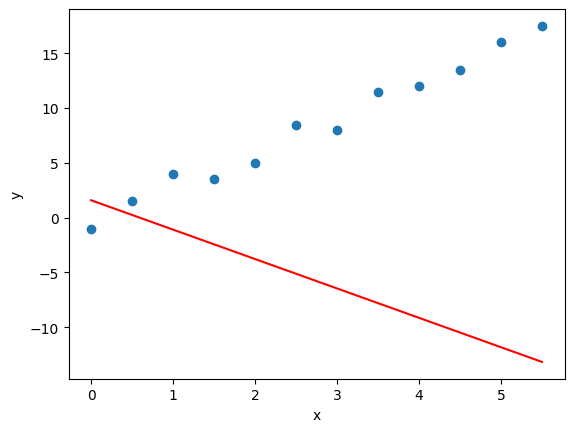

In [923]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, w*x + b, c='red')
ax.set_xlabel('x')
ax.set_ylabel('y');

In [924]:
def loss_calc(y, w, x, b):
    return ((y - w*x + b)**2).mean() # функция потерь МНК

loss = loss_calc(y, w, x, b)

d = {'loss': [loss], 'w': [w], 'b': [b]}
loss_list = [loss] # соберём все loss для построения графика в конце

df = pd.DataFrame(data=d) # датасет, куда мы положим все новые предложеные моделью веса (w, b) и рассчитанный loss
df.sort_values(by=['loss'], ascending=False, inplace=True)
df

,loss,w,b
0,404.096928,-2.683655,1.586905


In [925]:
def is_number_isdigit(s): # функция для парсинга str ответа от LLM
    n1 = s[0].replace('.','',1).replace('-','',1).strip().isdigit()
    n2 = s[1].replace('.','',1).replace('-','',1).strip().isdigit()
    return n1 * n2

def check_last_solutions(loss_list, last_nums): # функция, которая остановит оптимизацию, когда последних 4 значения loss функции < 1
    if len(loss_list) >= last_nums:
        last = loss_list[-last_nums:]
        return all(num < 1 for num in last)

In [926]:
def create_prompt(num_sol): # создаём промт
    meta_prompt_start = f'''Now you will help me minimize a function with two input variables w, b. I have some (w, b) pairs and the function values at those points.
The pairs are arranged in descending order based on their function values, where lower values are better.\n\n'''

    solutions = ''
    if num_sol > len(df.loss):
        num_sol = len(df.loss)

    for i in range(num_sol):
        solutions += f'''input:\nw={df.w.iloc[-num_sol + i]:.3f}, b={df.b.iloc[-num_sol + i]:.3f}\nvalue:\n{df.loss.iloc[-num_sol + i]:.3f}\n\n''' 
    
    meta_prompt_end = f'''Give me a new (w, b) pair that is different from all pairs above, and has a function value lower than
any of the above. Do not write code. The output must end with a pair [w, b], where w and b are numerical values.

w, b ='''

    return meta_prompt_start + solutions + meta_prompt_end

In [927]:
num_solutions = 10 # кол-во наблюдений, которое будем подавать в промт

for i in range(500):
    
    text = create_prompt(num_solutions)

    model_inputs = tokenizer([text], return_tensors="pt").to(device)
    model.to(device)

    generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=15,
            temperature=0.8,
            do_sample=True,
            pad_token_id=50256
            )

    output = tokenizer.batch_decode(generated_ids)[0]

    response = output.split("w, b =")[1].strip()
    
    if "\n" in response:
        response = response.split("\n")[0].strip()

    if "," in response:
        numbers = response.split(',')
    
    if is_number_isdigit(numbers):
        w, b = float(numbers[0].strip()), float(numbers[1].strip())
        loss = loss_calc(y, w, x, b)
        loss_list.append(loss)
        new_row = {'loss': loss, 'w': w, 'b': b}
        new_row_df = pd.DataFrame(new_row, index=[0])
        df = pd.concat([df, new_row_df], ignore_index=True)
        df.sort_values(by='loss', ascending=False, inplace=True)

        

    if i % 20 == 0:
        print(f'{w=} {b=} loss={loss:.3f}')

    if check_last_solutions(loss_list, 3):
        break


w=-100.0 b=1.0 loss=112593.792
w=-1.5 b=0.9 loss=245.704
w=2.2 b=1.1 loss=15.197
w=-2.0 b=-1.0 loss=246.792
w=3.5 b=1.2 loss=0.809


In [933]:
print(*loss_list[-15:], sep='\n')

246.79166666666666
15.55166666666667
15.55166666666667
14.914999999999997
44.41708333333333
44.41708333333333
28.161666666666665
26.42833333333333
21.763333333333335
46.583333333333336
20.939537499999997
20.939537499999997
0.80875
0.80875
0.6437500000000002


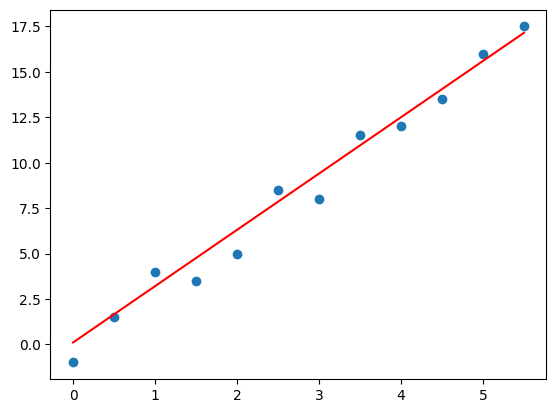

In [934]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, w*x + b, c='red');

number of step = 64


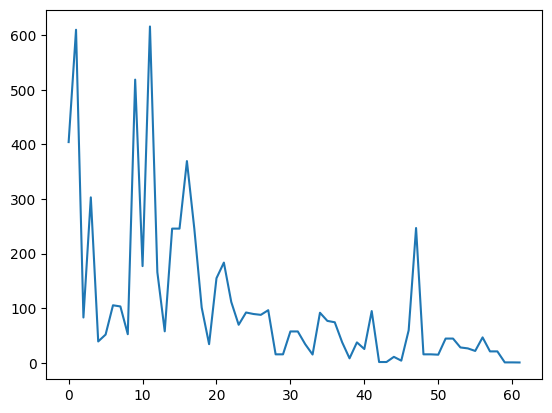

In [936]:
fig, ax = plt.subplots()
print(f'number of step = {len(loss_list)}')
# ax.plot(loss_list);
ax.plot([x for x in loss_list if x < 700]);
